# 1. 환경 설정

In [80]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
# 필요하다고 판단되는 라이브러리를 추가하세요.
import warnings
warnings.filterwarnings('ignore')
import re
import datetime
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler, LabelEncoder
from pycaret.classification import *
import optuna

## 1) 데이터 로드

In [75]:
data = pd.read_csv('data/train.csv')
data.head()

,Unnamed: 0,timestamp,A_x,A_y,A_z,B_x,B_y,B_z,label
0,0,2019-01-12 00:45:54.450,-0.259130,-0.834869,-0.485499,0.196409,NaN,0.384934,8
1,1,2000-01-01 01:37:06.440,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2
2,2,2019-01-12 00:45:33.900,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8
3,3,2000-01-01 00:46:22.680,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11
4,4,2000-01-01 00:49:56.620,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6


In [76]:
drop_cols = ['Unnamed: 0']
data.drop(drop_cols, axis = 1, inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000 entries, 0 to 99999
Data columns (total 8 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   timestamp  100000 non-null  object 
 1   A_x        90000 non-null   float64
 2   A_y        90000 non-null   float64
 3   A_z        90000 non-null   float64
 4   B_x        90000 non-null   float64
 5   B_y        90000 non-null   float64
 6   B_z        90000 non-null   float64
 7   label      100000 non-null  int64  
dtypes: float64(6), int64(1), object(1)
memory usage: 6.1+ MB


In [4]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
A_x,90000.0,-0.876639,0.464709,-5.132823,-1.016718,-0.958268,-0.764307,1.849398
A_y,90000.0,-0.110566,0.348463,-1.949310,-0.181035,-0.047425,0.060235,2.413866
A_z,90000.0,-0.013331,0.361989,-1.284750,-0.281950,-0.063756,0.222074,2.584467
B_x,90000.0,-0.780543,0.817925,-7.483251,-1.050645,-0.918144,-0.157112,5.372528
B_y,90000.0,0.116559,0.593224,-5.466767,-0.190546,0.023954,0.319651,7.182237
B_z,90000.0,0.167377,0.785482,-7.208220,-0.243964,0.113276,0.525970,6.766558
label,100000.0,5.945630,3.333515,1.000000,3.000000,7.000000,9.000000,11.000000


In [77]:
data.sort_values('timestamp', inplace = True)
data.head()

,timestamp,A_x,A_y,A_z,B_x,B_y,B_z,label
78632,2000-01-01 00:00:00.000,-0.988758,-0.144844,0.183325,-0.991851,-0.022659,-0.306466,6
78653,2000-01-01 00:00:00.020,-1.008465,NaN,0.156743,-0.976224,-0.040058,-0.277258,6
46005,2000-01-01 00:00:00.040,-0.991936,-0.143049,0.156618,-0.949758,-0.035796,-0.299548,6
92967,2000-01-01 00:00:00.060,-1.007975,-0.140831,0.155302,-1.006806,-0.013057,-0.289020,6
37258,2000-01-01 00:00:00.080,-0.991991,-0.159979,0.166965,NaN,0.015054,-0.293883,6


In [81]:
# 주어진 데이터프레임에서 timestamp 열을 datetime 형식으로 변환
data['timestamp'] = pd.to_datetime(data['timestamp'])

# 날짜 변수 생성 (년, 월, 일)
data['year'] = data['timestamp'].dt.year
data['month'] = data['timestamp'].dt.month
data['day'] = data['timestamp'].dt.day

# 시간 변수 생성 (시, 분, 초, 밀리초)
data['hour'] = data['timestamp'].dt.hour
data['minute'] = data['timestamp'].dt.minute
data['second'] = data['timestamp'].dt.second
data['millisecond'] = data['timestamp'].dt.microsecond // 1000  # 밀리초 단위로 변환

data.head()

,timestamp,A_x,A_y,A_z,B_x,B_y,B_z,label,year,month,day,hour,minute,second,millisecond
78632,2000-01-01 00:00:00.000,-0.988758,-0.144844,0.183325,-0.991851,-0.022659,-0.306466,6,2000,1,1,0,0,0,0
78653,2000-01-01 00:00:00.020,-1.008465,NaN,0.156743,-0.976224,-0.040058,-0.277258,6,2000,1,1,0,0,0,20
46005,2000-01-01 00:00:00.040,-0.991936,-0.143049,0.156618,-0.949758,-0.035796,-0.299548,6,2000,1,1,0,0,0,40
92967,2000-01-01 00:00:00.060,-1.007975,-0.140831,0.155302,-1.006806,-0.013057,-0.289020,6,2000,1,1,0,0,0,60
37258,2000-01-01 00:00:00.080,-0.991991,-0.159979,0.166965,NaN,0.015054,-0.293883,6,2000,1,1,0,0,0,80


- 인덱스와 timestamp 삭제
- 변수들의 결측치 10000개 채워야함

# 2. 데이터 분석

## 1) 단변량 분석

### 1) Target

label
2     12170
8     11497
1     11465
7     10594
10     9579
9      9282
11     9112
3      8305
4      7208
5      5411
6      5377
Name: count, dtype: int64
label
2     0.12170
8     0.11497
1     0.11465
7     0.10594
10    0.09579
9     0.09282
11    0.09112
3     0.08305
4     0.07208
5     0.05411
6     0.05377
Name: proportion, dtype: float64


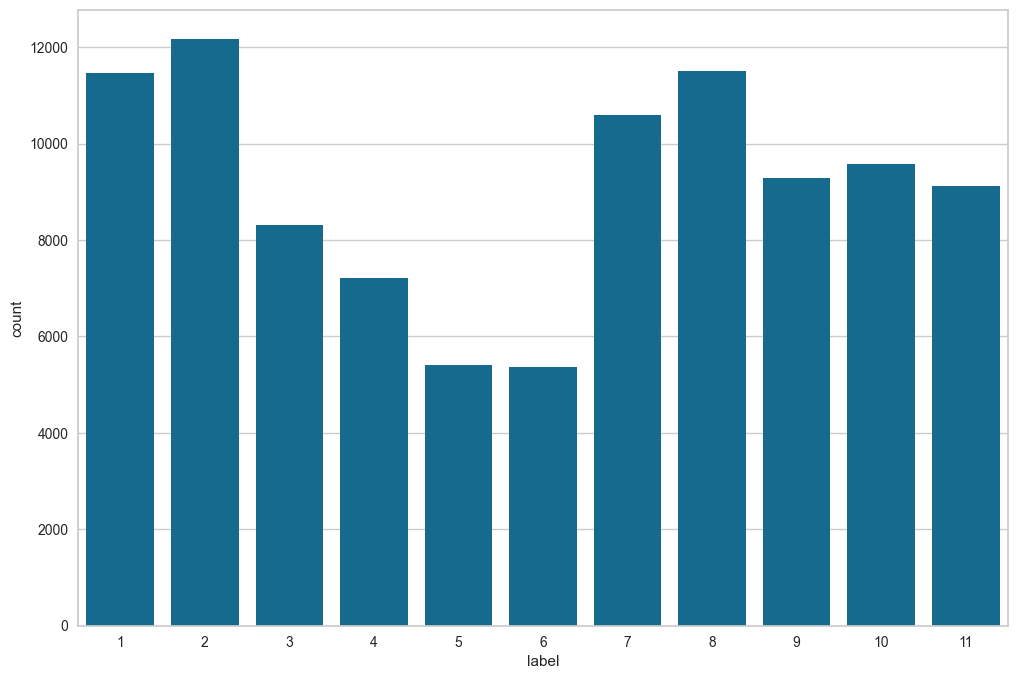

In [273]:
target = 'label'

print(data[target].value_counts())
print('=' * 30)
print(data[target].value_counts(normalize = True))
print('=' * 30)

plt.figure(figsize = (12, 8))
sns.countplot(x = data[target])
plt.show()

- 천천히 걷기, 계단 오르내리기, 서있기 의 수가 상대적으로 적다
- 걷기, 뛰기, 앉기, 누워있기 상대적으로 많다

### 2) 수치형 변수들

In [274]:
def eda_num(features, data):
    print(data[features].describe().T)
    plt.figure(figsize = (12, 12))
    for i in range(len(features)):
        plt.subplot(6, 2, (2 * i) + 1)
        sns.histplot(x = features[i], data = data, kde = True)
        plt.subplot(6, 2, (2 * i) + 2)
        sns.boxplot(x = features[i], data = data)
    plt.tight_layout()
    plt.show()

       count      mean       std       min       25%       50%       75%  \
A_x  90000.0 -0.876639  0.464709 -5.132823 -1.016718 -0.958268 -0.764307   
A_y  90000.0 -0.110566  0.348463 -1.949310 -0.181035 -0.047425  0.060235   
A_z  90000.0 -0.013331  0.361989 -1.284750 -0.281950 -0.063756  0.222074   
B_x  90000.0 -0.780543  0.817925 -7.483251 -1.050645 -0.918144 -0.157112   
B_y  90000.0  0.116559  0.593224 -5.466767 -0.190546  0.023954  0.319651   
B_z  90000.0  0.167377  0.785482 -7.208220 -0.243964  0.113276  0.525970   

          max  
A_x  1.849398  
A_y  2.413866  
A_z  2.584467  
B_x  5.372528  
B_y  7.182237  
B_z  6.766558  


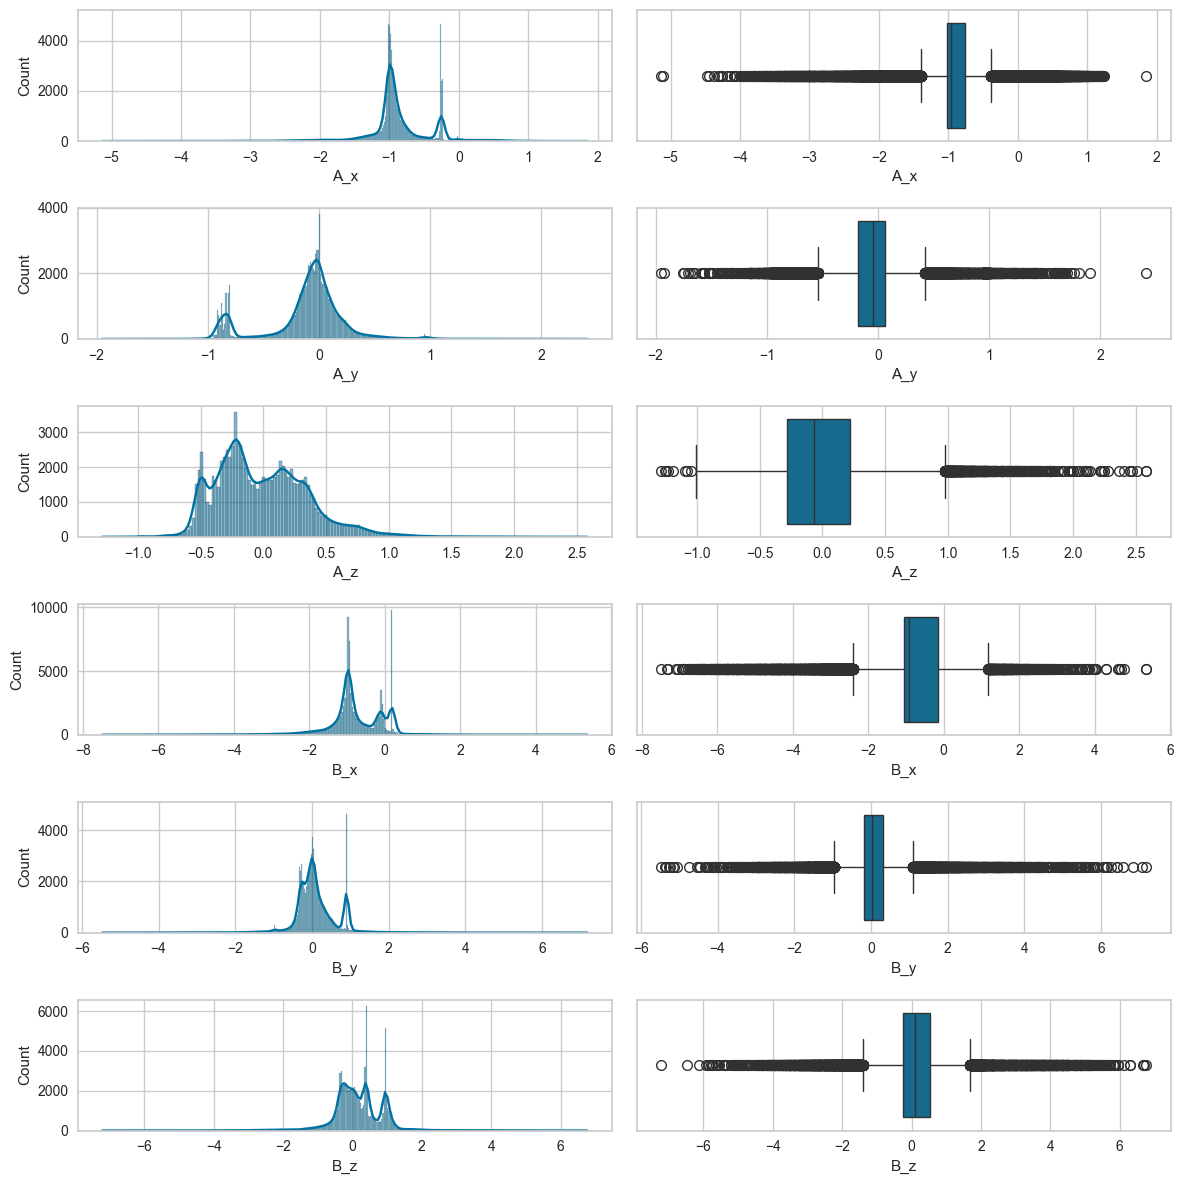

In [275]:
features = ['A_x', 'A_y', 'A_z', 'B_x', 'B_y', 'B_z']
eda_num(features, data)

- A 신체 부위는 활동에 따라 B 부위보다 더 많이 움직인다

## 2) 이변량 분석

In [276]:
def eda_num_cat(features, target, data):
    plt.figure(figsize=(15, 9))
    for i in range(len(features)):
        plt.subplot(2, 3, i + 1)
        sns.kdeplot(x=features[i], data=data, hue=target, common_norm=False, palette="Set2")
    plt.show()


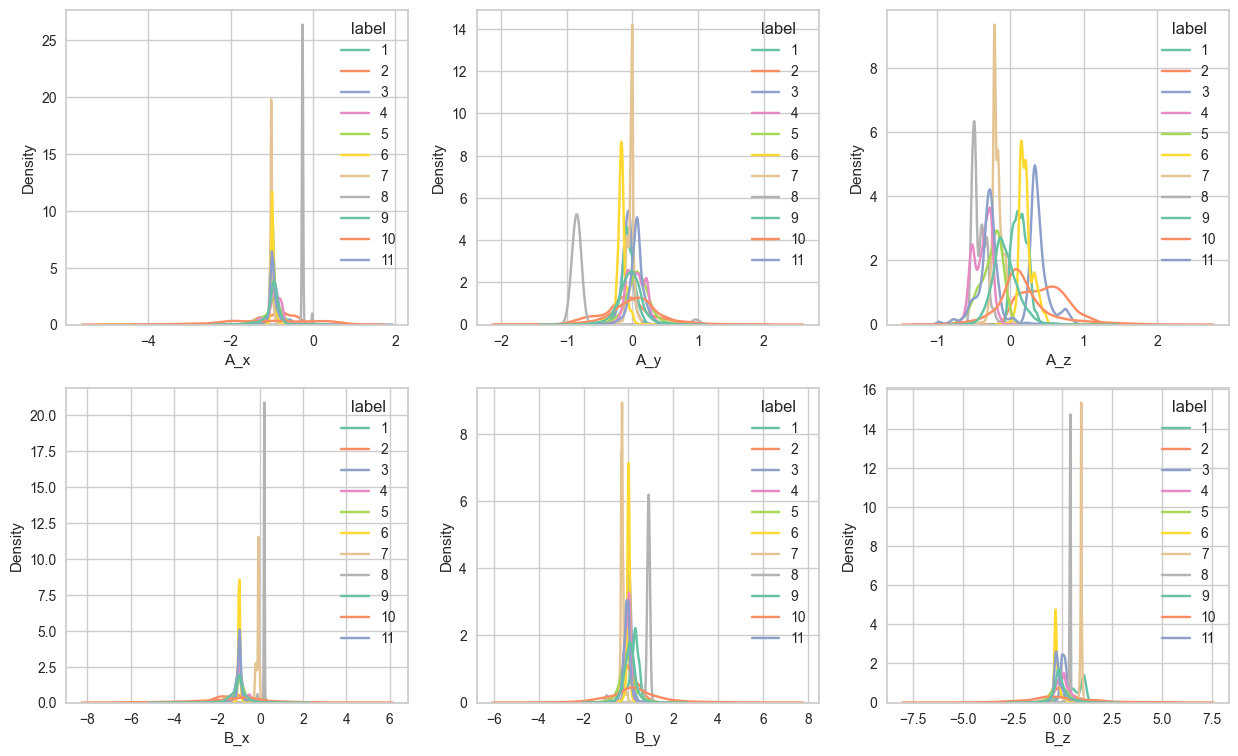

In [277]:
target = 'label'
features = ['A_x', 'A_y', 'A_z', 'B_x', 'B_y', 'B_z']
eda_num_cat(features, target, data)

- 대체로 앞뒤로 움직이는 활동들이다
- 행동에 따른 데이터 값들이 0의 주변이다

## 3) 결측치 처리

In [82]:
def na_check_modeling(data):
    target = 'label'
    X = data.drop(target, axis = 1)
    y = data.loc[:, target]
    
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.2, random_state = 42)
    
    pipeline = Pipeline([
        ('imputer', SimpleImputer()),  
        ('classifier', RandomForestClassifier(random_state = 42))  
    ])
    
    param_grid = {
        'imputer__strategy': ['mean', 'median'], 
    }
    
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy')
    grid_search.fit(X_train, y_train)
    
    print("Best param : ", grid_search.best_params_)
    print("Best accuracy: ", grid_search.best_score_)

In [85]:
target = 'label'
X = data.drop([target, 'timestamp'], axis = 1)
y = data.loc[:, target]    

In [88]:
X.head()

,A_x,A_y,A_z,B_x,B_y,B_z,year,month,day,hour,minute,second,millisecond
78632,-0.988758,-0.144844,0.183325,-0.991851,-0.022659,-0.306466,2000,1,1,0,0,0,0
78653,-1.008465,NaN,0.156743,-0.976224,-0.040058,-0.277258,2000,1,1,0,0,0,20
46005,-0.991936,-0.143049,0.156618,-0.949758,-0.035796,-0.299548,2000,1,1,0,0,0,40
92967,-1.007975,-0.140831,0.155302,-1.006806,-0.013057,-0.289020,2000,1,1,0,0,0,60
37258,-0.991991,-0.159979,0.166965,NaN,0.015054,-0.293883,2000,1,1,0,0,0,80


In [90]:
data.columns

Index(['timestamp', 'A_x', 'A_y', 'A_z', 'B_x', 'B_y', 'B_z', 'label', 'year',
       'month', 'day', 'hour', 'minute', 'second', 'millisecond'],
      dtype='object')

In [91]:
data.interpolate(method='linear', inplace=True)
data.isna().sum()

timestamp      0
A_x            0
A_y            0
A_z            0
B_x            0
B_y            0
B_z            0
label          0
year           0
month          0
day            0
hour           0
minute         0
second         0
millisecond    0
dtype: int64

In [92]:
target = 'label'
X = data.drop([target, 'timestamp'], axis = 1)
y = data.loc[:, target]    

X_train, X_val, y_train, y_val = train_test_split(X_median, y, test_size = 0.1, random_state = 42)

model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)
pred = model_rf.predict(X_val)

print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

[[1072   21    3   10    0    0    0    0    0   19    2]
 [  22 1170    0    2    0    0    0    0    0   21    6]
 [   5    5  734   27   35    1    0    0    0    0    1]
 [  10    0    2  724    0    0    0    0    0    0    0]
 [   0    1    1    0  515    0    0    0    0    0    0]
 [   2    1    0    0    0  555    0    0    0    5    2]
 [   0    0    0    0    0    0 1060    0    0    0    0]
 [   0    0    0    0    0    0    0 1158    0    0    0]
 [   0    0    0    0    0    0    0    0  895    0    0]
 [  10   12    0    0    0    0    0    0    0  944   18]
 [   6    1    0    1    0    0    0    0    0   15  906]]
              precision    recall  f1-score   support

           1       0.95      0.95      0.95      1127
           2       0.97      0.96      0.96      1221
           3       0.99      0.91      0.95       808
           4       0.95      0.98      0.97       736
           5       0.94      1.00      0.97       517
           6       1.00      0.98   

## 4) 변수 중요도 분석

### 1) 전체 세부 행동

In [68]:
# 변수의 특성 중요도 계산하기
def plot_feature_importance(importance, names, result_only = False, topn = 'all'):
    feature_importance = np.array(importance)
    feature_name = np.array(names)

    data={'feature_name':feature_name,'feature_importance':feature_importance}
    fi_temp = pd.DataFrame(data)

    #변수의 특성 중요도 순으로 정렬하기
    fi_temp.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_temp.reset_index(drop=True, inplace = True)

    if topn == 'all' :
        fi_df = fi_temp.copy()
    else :
        fi_df = fi_temp.iloc[:topn]

    #변수의 특성 중요도 그래프로 그리기
    if result_only == False :
        plt.figure(figsize=(10,20))
        sns.barplot(x='feature_importance', y='feature_name', data = fi_df)

        plt.xlabel('importance')
        plt.ylabel('feature name')
        plt.grid()

    return fi_df

In [283]:
imputer = SimpleImputer(strategy = 'median')
X_median=imputer.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_median, y, test_size = 0.2, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_samples_leaf=1,
                       min_samples_split=2, min_weight_fraction_leaf=0.0,
                       n_estimators=100, n_jobs=None, oob_score=False,
                       random_state=42, verbose=0, warm_start=False)

In [284]:
feature_importances = plot_feature_importance(model_rf.feature_importances_, X.columns, result_only = True)
feature_importances

,feature_name,feature_importance
0,A_z,0.213232
1,B_x,0.185962
2,B_z,0.172930
3,A_x,0.162025
4,A_y,0.136128
5,B_y,0.129722


- A 부위의 위아래 움직임이 가장 중요
- y축 데이터가 덜 중요하다

### 2) 정적 동적 유무

In [63]:
data['is_dynamic'] = np.where(data['label'].isin([1, 2, 3]), 1, np.where(data['label'].isin([4, 5]), 2, np.where(data['label'].isin([9, 10, 11]), 3, 0)))
data.head()

,A_x,A_y,A_z,B_x,B_y,B_z,label,is_dynamic
0,-0.259130,-0.834869,-0.485499,0.196409,0.023954,0.384934,8,0
1,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2,1
2,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8,0
3,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11,3
4,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6,0


In [64]:
target = 'is_dynamic'
X = data.drop([target, 'label'], axis = 1)
y = data.loc[:, target]    

In [65]:
imputer = SimpleImputer(strategy = 'median')
X_median=imputer.fit_transform(X)
X_train, X_val, y_train, y_val = train_test_split(X_median, y, test_size = 0.1, random_state = 42)
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [66]:
pred = model_rf.predict(X_val)

print(accuracy_score(y_val, pred))
print(confusion_matrix(y_val, pred))
print(classification_report(y_val, pred))

0.9112
[[2686   30    1   41]
 [   9 2896  236  120]
 [   3  287  941   20]
 [  10  118   13 2589]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2758
           1       0.87      0.89      0.88      3261
           2       0.79      0.75      0.77      1251
           3       0.93      0.95      0.94      2730

    accuracy                           0.91     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.91      0.91      0.91     10000



In [69]:
feature_importances = plot_feature_importance(model_rf.feature_importances_, X.columns, result_only = True)
feature_importances

,feature_name,feature_importance
0,A_z,0.261219
1,B_x,0.206825
2,B_z,0.175017
3,A_x,0.125821
4,A_y,0.125761
5,B_y,0.105357


- 정적, 동적 유무에서는 A부위의 X축 데이터가 별로 중요하지 않았다
- 세부 활동에서보다 A_z, B_x의 변수 중요도가 더 중요했다

# 3. 모델링

In [70]:
medians = data.median()
data = data.fillna(medians)
data.isna().sum()

A_x           0
A_y           0
A_z           0
B_x           0
B_y           0
B_z           0
label         0
is_dynamic    0
dtype: int64

### 1) 정적, 동적 유무 분류

In [ ]:
def modeling(data, target, models):
    result = {}
    X = data.drop([list(data)[]6:], axis = 1)
    y = data.loc[:, target]
    le = LabelEncoder()
    y2 = le.fit_transform(y)
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)
    X_train2, X_val2, y_train2, y_val2 = train_test_split(X, y2, test_size = 0.1, random_state = 42) # XGB 위해서

    for model_name, model in models.items():
        if model_name == 'XGBoost':
            model.fit(X_train2, y_train2)
            pred = model.predict(X_val2)
            print(model_name)
            print(accuracy_score(y_val2, pred))
            print(confusion_matrix(y_val2, pred))
            print(classification_report(y_val2, pred))
            print('=' * 60)
        else:
            model.fit(X_train, y_train)
            pred = model.predict(X_val)
            print(model_name)
            print(accuracy_score(y_val, pred))
            print(confusion_matrix(y_val, pred))
            print(classification_report(y_val, pred))
            print('=' * 60)

In [ ]:
models = {
    'Random Forest' :  RandomForestClassifier(random_state = 42), 
    'XGBoost' : XGBClassifier(random_state = 42, device = 'gpu'), 
    'LightGBM' : LGBMClassifier(random_state = 42, verbose = -1, device = 'gpu'), 
    'CatBoost' : CatBoostClassifier(random_state = 42, task_type = 'GPU', verbose = 0)
}

modeling(data, target, models)

In [71]:
target = 'is_dynamic'
X = data.drop([target, 'label'], axis = 1)
y = data.loc[:, target]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [ ]:
for 

#### 1) Random Forest

In [72]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train, y_train)
p_rf_1 = model_rf.predict(X_val)

print(accuracy_score(y_val, p_rf_1))
print(confusion_matrix(y_val, p_rf_1))
print(classification_report(y_val, p_rf_1))

0.9112
[[2686   30    1   41]
 [   9 2896  236  120]
 [   3  287  941   20]
 [  10  118   13 2589]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2758
           1       0.87      0.89      0.88      3261
           2       0.79      0.75      0.77      1251
           3       0.93      0.95      0.94      2730

    accuracy                           0.91     10000
   macro avg       0.90      0.89      0.89     10000
weighted avg       0.91      0.91      0.91     10000



In [430]:
rf = plot_feature_importance(model_rf.feature_importances_, list(X_train), True)
rf.head(6)

,feature_name,feature_importance
0,B_x,0.345872
1,B_z,0.186641
2,A_y,0.155304
3,A_z,0.149865
4,B_y,0.094245
5,A_x,0.068072


#### 2) XGBoost

In [457]:
model_xgb = XGBClassifier(random_state = 42, device = 'gpu')
model_xgb.fit(X_train, y_train)
p_xgb_1 = model_xgb.predict(X_val)

print(accuracy_score(y_val, p_xgb_1))
print(confusion_matrix(y_val, p_xgb_1))
print(classification_report(y_val, p_xgb_1))

0.9884
[[2676   82]
 [  34 7208]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2758
           1       0.99      1.00      0.99      7242

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [458]:
xgb = plot_feature_importance(model_xgb.feature_importances_, list(X_train), True)
xgb.head(6)

,feature_name,feature_importance
0,B_x,0.518487
1,A_z,0.179429
2,B_z,0.120351
3,A_y,0.080393
4,B_y,0.051063
5,A_x,0.050277


In [459]:
joblib.dump(model_xgb, 'model1.pkl')

['model1.pkl']

#### 3) Light GBM

In [433]:
model_lgb = LGBMClassifier(random_state = 42, verbose = -1, device = 'gpu')
model_lgb.fit(X_train, y_train)
p_lgb_1 = model_lgb.predict(X_val)

print(accuracy_score(y_val, p_lgb_1))
print(confusion_matrix(y_val, p_lgb_1))
print(classification_report(y_val, p_lgb_1))

0.9872
[[2672   86]
 [  42 7200]]
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      2758
           1       0.99      0.99      0.99      7242

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



In [434]:
lgb = plot_feature_importance(model_lgb.feature_importances_, list(X_train), True)
lgb.head(6)

,feature_name,feature_importance
0,B_z,606
1,A_z,588
2,B_x,536
3,A_y,495
4,A_x,395
5,B_y,380


#### 4) CatBoost

In [435]:
model_cat = CatBoostClassifier(random_state = 42, task_type = 'GPU', verbose = 0)
model_cat.fit(X_train, y_train)
p_cat_1 = model_cat.predict(X_val)

print(accuracy_score(y_val, p_cat_1))
print(confusion_matrix(y_val, p_cat_1))
print(classification_report(y_val, p_cat_1))

0.9876
[[2670   88]
 [  36 7206]]
              precision    recall  f1-score   support

           0       0.99      0.97      0.98      2758
           1       0.99      1.00      0.99      7242

    accuracy                           0.99     10000
   macro avg       0.99      0.98      0.98     10000
weighted avg       0.99      0.99      0.99     10000



In [436]:
cat = plot_feature_importance(model_cat.feature_importances_, list(X_train), True)
cat.head(6)

,feature_name,feature_importance
0,B_x,23.932424
1,A_z,22.571602
2,B_z,19.190188
3,A_y,14.507457
4,A_x,9.998508
5,B_y,9.799822


### 2) 정적 세부 분류

In [437]:
data_nd = data.loc[data['is_dynamic'] == 0]
data_nd.head()

,A_x,A_y,A_z,B_x,B_y,B_z,label,is_dynamic
0,-0.259130,-0.834869,-0.485499,0.196409,0.023954,0.384934,8,0
2,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8,0
4,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6,0
7,-0.958268,0.984155,-0.231787,-0.114444,-0.973016,0.227619,8,0
8,-0.257591,-0.851943,-0.438682,0.195110,0.901728,0.379608,8,0


In [438]:
target = 'label'
X2 = data_nd.drop([target, 'is_dynamic'], axis = 1)
y2 = data_nd.loc[:, target]
y2_2 = y2.map({6 : 0, 7 : 1, 8 : 2})

X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size = 0.1, random_state = 42)
X_train2_2, X_val2_2, y_train2_2, y_val2_2 = train_test_split(X2, y2_2, test_size = 0.1, random_state = 42) # XGB 위해서

#### 1) Random Forest

In [439]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train2, y_train2)
p_rf_2 = model_rf.predict(X_val2)

print(accuracy_score(y_val2, p_rf_2))
print(confusion_matrix(y_val2, p_rf_2))
print(classification_report(y_val2, p_rf_2))

0.9989078995267565
[[ 522    0    1]
 [   1 1053    0]
 [   1    0 1169]]
              precision    recall  f1-score   support

           6       1.00      1.00      1.00       523
           7       1.00      1.00      1.00      1054
           8       1.00      1.00      1.00      1170

    accuracy                           1.00      2747
   macro avg       1.00      1.00      1.00      2747
weighted avg       1.00      1.00      1.00      2747



In [440]:
rf = plot_feature_importance(model_rf.feature_importances_, list(X_train), True)
rf.head(6)

,feature_name,feature_importance
0,B_z,0.249724
1,A_x,0.217431
2,B_x,0.160979
3,A_z,0.128730
4,A_y,0.124674
5,B_y,0.118462


#### 2) XGBoost

In [441]:
model_xgb = XGBClassifier(random_state = 42, device = 'gpu')
model_xgb.fit(X_train2_2, y_train2_2)
p_xgb_2 = model_xgb.predict(X_val2_2)

print(accuracy_score(y_val2_2, p_xgb_2))
print(confusion_matrix(y_val2_2, p_xgb_2))
print(classification_report(y_val2_2, p_xgb_2))

0.9992719330178377
[[ 521    1    1]
 [   0 1054    0]
 [   0    0 1170]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       523
           1       1.00      1.00      1.00      1054
           2       1.00      1.00      1.00      1170

    accuracy                           1.00      2747
   macro avg       1.00      1.00      1.00      2747
weighted avg       1.00      1.00      1.00      2747



In [442]:
xgb = plot_feature_importance(model_xgb.feature_importances_, list(X_train), True)
xgb.head(6)

,feature_name,feature_importance
0,A_x,0.377674
1,B_z,0.278160
2,A_z,0.219102
3,B_y,0.056233
4,A_y,0.043614
5,B_x,0.025218


#### 3) Light GBM

In [460]:
model_lgb = LGBMClassifier(random_state = 42, verbose = -1, device = 'gpu')
model_lgb.fit(X_train2, y_train2)
p_lgb_2 = model_lgb.predict(X_val2)

print(accuracy_score(y_val2, p_lgb_2))
print(confusion_matrix(y_val2, p_lgb_2))
print(classification_report(y_val2, p_lgb_2))

0.9996359665089188
[[ 522    0    1]
 [   0 1054    0]
 [   0    0 1170]]
              precision    recall  f1-score   support

           6       1.00      1.00      1.00       523
           7       1.00      1.00      1.00      1054
           8       1.00      1.00      1.00      1170

    accuracy                           1.00      2747
   macro avg       1.00      1.00      1.00      2747
weighted avg       1.00      1.00      1.00      2747



In [461]:
lgb = plot_feature_importance(model_lgb.feature_importances_, list(X_train), True)
lgb.head(6)

,feature_name,feature_importance
0,B_z,1674
1,A_z,1621
2,B_y,1611
3,A_y,1486
4,B_x,1416
5,A_x,1192


In [462]:
joblib.dump(model_lgb, 'model2_1.pkl')

['model2_1.pkl']

#### 4) CatBoost

In [445]:
model_cat = CatBoostClassifier(random_state = 42, task_type = 'GPU', verbose = 0)
model_cat.fit(X_train2, y_train2)
p_cat_2 = model_cat.predict(X_val2)

print(accuracy_score(y_val2, p_cat_2))
print(confusion_matrix(y_val2, p_cat_2))
print(classification_report(y_val2, p_cat_2))

0.9992719330178377
[[ 521    0    2]
 [   0 1054    0]
 [   0    0 1170]]
              precision    recall  f1-score   support

           6       1.00      1.00      1.00       523
           7       1.00      1.00      1.00      1054
           8       1.00      1.00      1.00      1170

    accuracy                           1.00      2747
   macro avg       1.00      1.00      1.00      2747
weighted avg       1.00      1.00      1.00      2747



In [446]:
cat = plot_feature_importance(model_cat.feature_importances_, list(X_train), True)
cat.head(6)

,feature_name,feature_importance
0,A_x,23.261268
1,B_y,18.230001
2,A_y,16.707951
3,B_z,16.491474
4,B_x,15.370448
5,A_z,9.938859


### 3) 동적 세부 분류

In [447]:
data_bd = data.loc[data['is_dynamic'] == 1]
data_bd.head()

,A_x,A_y,A_z,B_x,B_y,B_z,label,is_dynamic
1,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2,1
3,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11,1
5,-0.654583,0.068285,-0.029109,-0.176341,-0.256252,-0.510816,2,1
6,-1.009269,0.003985,-0.263406,-0.918144,-0.325362,-0.131165,3,1
9,-0.984360,-0.182248,0.630760,-0.918144,0.044664,0.484233,10,1


In [62]:
data['is_dynamic'] = np.where(data['label'].isin([1, 2, 3]), 1, np.where(data['label'].isin([4, 5]), 2, np.where(data['label'].isin([9, 10, 11]), 3, 0)))
data.head()

,A_x,A_y,A_z,B_x,B_y,B_z,label,is_dynamic
0,-0.259130,-0.834869,-0.485499,0.196409,0.023954,0.384934,8,0
1,0.370490,0.175042,0.122625,-0.338242,0.358245,0.126491,2,1
2,-0.257837,-0.881947,-0.391895,0.196027,0.894537,0.411221,8,0
3,-0.937753,-0.055961,0.362041,-0.929881,0.087673,0.134609,11,3
4,-0.988320,-0.190390,0.157909,-0.954669,-0.024810,-0.388420,6,0


In [61]:
data.drop('dynamic', axis = 1,  inplace = True)

In [48]:
data_t1 = data.loc[data['is_dynamic'] == 1]
data_t2 = data.loc[data['is_dynamic'] == 2]
data_t3 = data.loc[data['is_dynamic'] == 3]

In [50]:
target = 'label'
X3 = data_t0.drop([target, 'is_dynamic', 'dynamic'], axis = 1)
y3 = data_t0.loc[:, target]

X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, y3, test_size = 0.1, random_state = 42)

In [51]:
target = 'label'
X4 = data_t1.drop([target, 'is_dynamic', 'dynamic'], axis = 1)
y4 = data_t1.loc[:, target]

X_train4, X_val4, y_train4, y_val4 = train_test_split(X4, y4, test_size = 0.1, random_state = 42)

In [52]:
target = 'label'
X5 = data_t2.drop([target, 'is_dynamic', 'dynamic'], axis = 1)
y5 = data_t2.loc[:, target]

X_train5, X_val5, y_train5, y_val5 = train_test_split(X5, y5, test_size = 0.1, random_state = 42)

#### 1) Random Forest

In [53]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train3, y_train3)
p_rf_3 = model_rf.predict(X_val3)

print(accuracy_score(y_val3, p_rf_3))
print(confusion_matrix(y_val3, p_rf_3))
print(classification_report(y_val3, p_rf_3))

0.8951158422041328
[[1005   61   50]
 [ 101 1132   12]
 [ 100   11  722]]
              precision    recall  f1-score   support

           1       0.83      0.90      0.87      1116
           2       0.94      0.91      0.92      1245
           3       0.92      0.87      0.89       833

    accuracy                           0.90      3194
   macro avg       0.90      0.89      0.89      3194
weighted avg       0.90      0.90      0.90      3194



In [54]:
joblib.dump(model_rf, 'model2_2_1.pkl')

['model2_2_1.pkl']

In [55]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train4, y_train4)
p_rf_4 = model_rf.predict(X_val4)

print(accuracy_score(y_val4, p_rf_4))
print(confusion_matrix(y_val4, p_rf_4))
print(classification_report(y_val4, p_rf_4))

0.8882725832012678
[[644  60]
 [ 81 477]]
              precision    recall  f1-score   support

           4       0.89      0.91      0.90       704
           5       0.89      0.85      0.87       558

    accuracy                           0.89      1262
   macro avg       0.89      0.88      0.89      1262
weighted avg       0.89      0.89      0.89      1262



In [56]:
joblib.dump(model_rf, 'model2_2_2.pkl')

['model2_2_2.pkl']

In [57]:
model_rf = RandomForestClassifier(random_state = 42)
model_rf.fit(X_train5, y_train5)
p_rf_5 = model_rf.predict(X_val5)

print(accuracy_score(y_val5, p_rf_5))
print(confusion_matrix(y_val5, p_rf_5))
print(classification_report(y_val5, p_rf_5))

0.9378127233738385
[[899  12  19]
 [ 11 867  55]
 [ 10  67 858]]
              precision    recall  f1-score   support

           9       0.98      0.97      0.97       930
          10       0.92      0.93      0.92       933
          11       0.92      0.92      0.92       935

    accuracy                           0.94      2798
   macro avg       0.94      0.94      0.94      2798
weighted avg       0.94      0.94      0.94      2798



In [58]:
joblib.dump(model_rf, 'model2_2_3.pkl')

['model2_2_3.pkl']

#### 2) XGBoost

In [24]:
model_xgb = XGBClassifier(random_state = 42, device = 'gpu')
model_xgb.fit(X_train3_2, y_train3_2)
p_xgb_3 = model_xgb.predict(X_val3_2)

print(accuracy_score(y_val3_2, p_xgb_3))
print(confusion_matrix(y_val3_2, p_xgb_3))
print(classification_report(y_val3_2, p_xgb_3))

0.797576301615799
[[ 994   58   22   25   41]
 [  90 1090    5    4   10]
 [  60   10  616   97   81]
 [  44    0   62  580   26]
 [ 130   26   65   46  274]]
              precision    recall  f1-score   support

           0       0.75      0.87      0.81      1140
           1       0.92      0.91      0.91      1199
           2       0.80      0.71      0.75       864
           3       0.77      0.81      0.79       712
           4       0.63      0.51      0.56       541

    accuracy                           0.80      4456
   macro avg       0.78      0.76      0.77      4456
weighted avg       0.80      0.80      0.79      4456



In [452]:
xgb = plot_feature_importance(model_xgb.feature_importances_, list(X_train), True)
xgb.head(6)

,feature_name,feature_importance
0,A_z,0.351336
1,A_x,0.202686
2,B_z,0.150808
3,B_x,0.119562
4,B_y,0.101606
5,A_y,0.074002


#### 3) Light GBM

In [25]:
model_lgb = LGBMClassifier(random_state = 42, verbose = -1, device = 'gpu')
model_lgb.fit(X_train3, y_train3)
p_lgb_3 = model_lgb.predict(X_val3)

print(accuracy_score(y_val3, p_lgb_3))
print(confusion_matrix(y_val3, p_lgb_3))
print(classification_report(y_val3, p_lgb_3))

0.8779714738510301
[[645  59]
 [ 95 463]]
              precision    recall  f1-score   support

           4       0.87      0.92      0.89       704
           5       0.89      0.83      0.86       558

    accuracy                           0.88      1262
   macro avg       0.88      0.87      0.88      1262
weighted avg       0.88      0.88      0.88      1262



In [454]:
lgb = plot_feature_importance(model_lgb.feature_importances_, list(X_train), True)
lgb.head(6)

,feature_name,feature_importance
0,A_z,4316
1,B_z,4264
2,B_x,4124
3,A_x,3984
4,A_y,3735
5,B_y,3577


#### 4) CatBoost

In [455]:
model_cat = CatBoostClassifier(random_state = 42, task_type = 'GPU', verbose = 0)
model_cat.fit(X_train3, y_train3)
p_cat_3 = model_cat.predict(X_val3)

print(accuracy_score(y_val3, p_cat_3))
print(confusion_matrix(y_val3, p_cat_3))
print(classification_report(y_val3, p_cat_3))

0.81872070581748
[[ 921   49   33   22   41    9   19   20]
 [  73 1042    3    2   13    8   61   19]
 [  55    4  618   98   80    3    4    6]
 [  22    1   90  569   32    2    1    8]
 [ 106    8   87   42  307    2    4    5]
 [  11    1    2    1    1  880    7   11]
 [  25   40    8    3    5   24  830   67]
 [  13    2    0    4    0   11   47  772]]
              precision    recall  f1-score   support

           1       0.75      0.83      0.79      1114
           2       0.91      0.85      0.88      1221
           3       0.73      0.71      0.72       868
           4       0.77      0.78      0.78       725
           5       0.64      0.55      0.59       561
           9       0.94      0.96      0.95       914
          10       0.85      0.83      0.84      1002
          11       0.85      0.91      0.88       849

    accuracy                           0.82      7254
   macro avg       0.81      0.80      0.80      7254
weighted avg       0.82      0.82      0.8

In [456]:
cat = plot_feature_importance(model_cat.feature_importances_, list(X_train), True)
cat.head(6)

,feature_name,feature_importance
0,A_z,30.694694
1,B_z,17.343239
2,B_x,13.795918
3,A_x,13.749006
4,A_y,12.601959
5,B_y,11.815184


In [420]:
acc = []
for i in range(6) : 
    top_n_feature = cat.loc[:i, 'feature_name']
    X_train_n = X_train3[top_n_feature]
    X_val_n = X_val3[top_n_feature]
    model_cat.fit(X_train_n, y_train3)
    pred = model_cat.predict(X_val_n)
    acc.append(accuracy_score(y_val3, pred))
    print(i, end = ' ')

0 1 2 3 4 5 

# 4. 테스트 데이터 예측

In [466]:
def predict_new_data(test_path, sub_path):
    # 1. 데이터 로드 및 전처리
    submission = pd.read_csv(sub_path)
    X_test = pd.read_csv(test_path)
    drop_cols = ['Unnamed: 0', 'timestamp' ]
    X_test.drop(drop_cols, axis = 1, inplace = True)

    # 2. 저장된 모델 로드
    model1 = joblib.load('model1.pkl')
    model2_1 = joblib.load('model2_1.pkl')
    model2_2 = joblib.load('model2_2.pkl')
    
    # 4. 동적 정적 유무 예측
    pred1= model1.predict(X_test)
    index_0 = [i for i, value in enumerate(pred1) if value == 0]
    index_1 = [i for i, value in enumerate(pred1) if value == 1]

    # 5. 동적, 정적 세부 예측
    X_test_nd = X_test.loc[index_0, :]
    X_test_d = X_test.loc[index_1, :]
    pred2_1 = model2_1.predict(X_test_nd)
    pred2_2 = model2_2.predict(X_test_d)

    # 6. 예측 결과 합치기
    pred2_1 = np.ravel(pred2_1)
    pred2_2 = np.ravel(pred2_2)
    
    result_nd = pd.DataFrame({'Index': index_0, 'Prediction': pred2_1})
    result_d = pd.DataFrame({'Index': index_1, 'Prediction': pred2_2})
    
    result_nd = result_nd.set_index('Index')
    result_d = result_d.set_index('Index')
    
    merged_df = pd.concat([result_nd, result_d], axis=0)
    merged_df = merged_df.sort_index()
    
    pred_total = merged_df['Prediction']
    submission['label'] = pred_total
    return submission

In [467]:
test_path = 'data/test.csv'
sub_path = 'data/sample.csv'
submission2=predict_new_data(test_path, sub_path)
submission2.head() # xgb-> lgb + rf

,ID,label
0,0,6
1,1,4
2,2,11
3,3,9
4,4,7


In [468]:
submission2.to_csv('submission2.csv',index=False)

In [369]:
test_path = 'data/test.csv'
sub_path = 'data/sample.csv'
submission=predict_new_data(test_path, sub_path)
submission.head() # rf -> cat + cat

,ID,label
0,0,6
1,1,4
2,2,11
3,3,9
4,4,7


In [371]:
submission.to_csv('submission.csv',index=False)

In [370]:
sub_path = 'data/sample.csv'
sub = pd.read_csv(sub_path)
sub.head()

,ID,label
0,0,1
1,1,4
2,2,11
3,3,9
4,4,7
